## Путешествие по Спрингфилду.

### Задание: классификация картинок с Симпсонами

Выполнил Булдаков Н.

Ник на Stepik: **Никита Булдаков**

Ник на соревновании kaggle: **Никита_Булдаков_504023144**

При возникновении вопросов прошу писать в телеграм: **@BuldakovN**

In [ ]:
import torch
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

import torchvision
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# Работа с данными

In [3]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)

cuda


In [77]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # трансформер для тренировки, делающий аугментации (отзеркаливание, поворот, обрезка)
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.to(DEVICE)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation((-30, 30)),
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        # обычный трансформер
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.to(DEVICE)),
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        if self.mode == 'train':
            x = train_transform(x)
        else:
            x = transform(x)
        files = [str(i) for i in self.files]
        file = files[index]
        if self.mode == 'test':
            return x, file
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [5]:
# небольшая функция для отрисовки картинок
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.cpu()
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [6]:
""" Если запускать в колабе
TRAIN_DIR = Path('train/dataset')
TEST_DIR = Path('test/testset')
"""
# Если запускать на Kaggle
TRAIN_DIR = Path('/kaggle/input/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('/kaggle/input/journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [41]:
from sklearn.model_selection import train_test_split
# деление датасета на трейн и валидацию
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

Постотрим на датасет

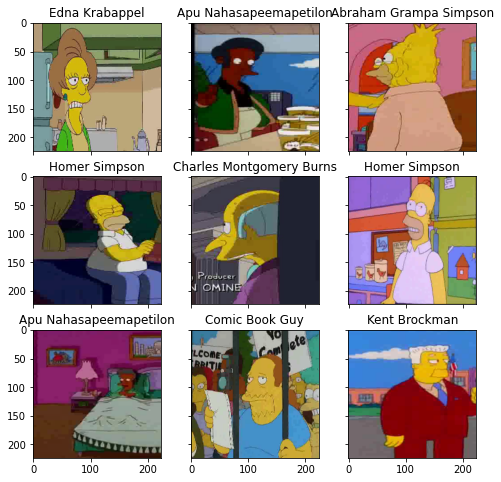

In [9]:
# валидационная выборка
val_dataset = SimpsonsDataset(val_files, mode='val')
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data, \
          title=img_label,plt_ax=fig_x)

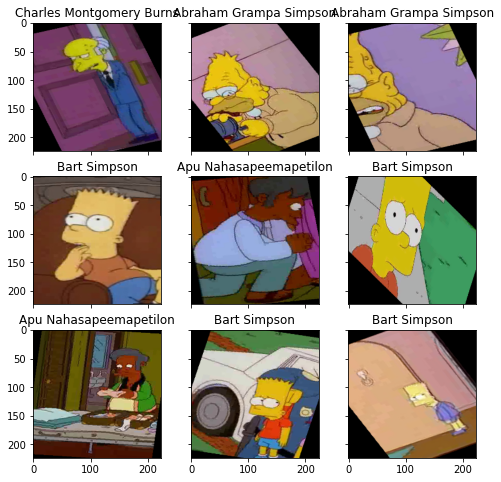

In [78]:
# тестовая выборка
val_dataset = SimpsonsDataset(val_files, mode='train')
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data, \
          title=img_label,plt_ax=fig_x)

# Построение нейросети

Будем использовать претрейненную модель ResNet18.

In [11]:
# алгоритм тренировки модели
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    f1_score_history = []
      
    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        f1_score_history.append(f1_score(labels.cpu(), preds.cpu(), average='micro'))
              
    train_loss = running_loss / processed_data
    train_acc = np.array(f1_score_history).mean()
    return train_loss, train_acc

In [12]:
# алгоритм валидации модели
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    f1_score_history = []

    for inputs, labels in (val_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
        f1_score_history.append(f1_score(labels.cpu(), preds.cpu(), average='micro'))
        
    val_loss = running_loss / processed_size
    val_acc = np.array(f1_score_history).mean()
    return val_loss, val_acc

In [34]:
import copy
# алгоритм тренировки одной эпохи
def train(train_files, val_files, model, epochs, batch_size):
    # загружаем даталоадеры
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    opt = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    for epoch in (range(epochs)):
        print(f"Epoch {epoch+1}:")
        # тренируем
        train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
        print()
        print("train_loss", train_loss)
        print("train_acc", train_acc)
        # валидируем
        val_loss, val_acc = eval_epoch(model, val_loader, criterion)
        print()
        print("val_loss", val_loss)
        print("val_acc", val_acc)
        print()
        # сохраняем
        history.append((train_loss, train_acc, val_loss, val_acc))
            
    return history

In [24]:
# просто получение предикта
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [79]:
n_classes = len(np.unique(train_val_labels))
print(f"Количество классов: {n_classes}")

from torchvision import models
# загружаем нашу модель
model = models.resnet18(pretrained=True).to(DEVICE)

Количество классов: 42


## Запустим обучение

In [63]:
# загружаем датасеты
val_dataset = SimpsonsDataset(val_files, mode='val',)

train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
# запускаем обучение
if __name__ == "__main__":
    history = train(train_dataset,
                    val_dataset,
                    model=model,
                    epochs=10,
                    batch_size=256)

## Построим кривые обучения

In [45]:
loss, acc, val_loss, val_acc = zip(*history)

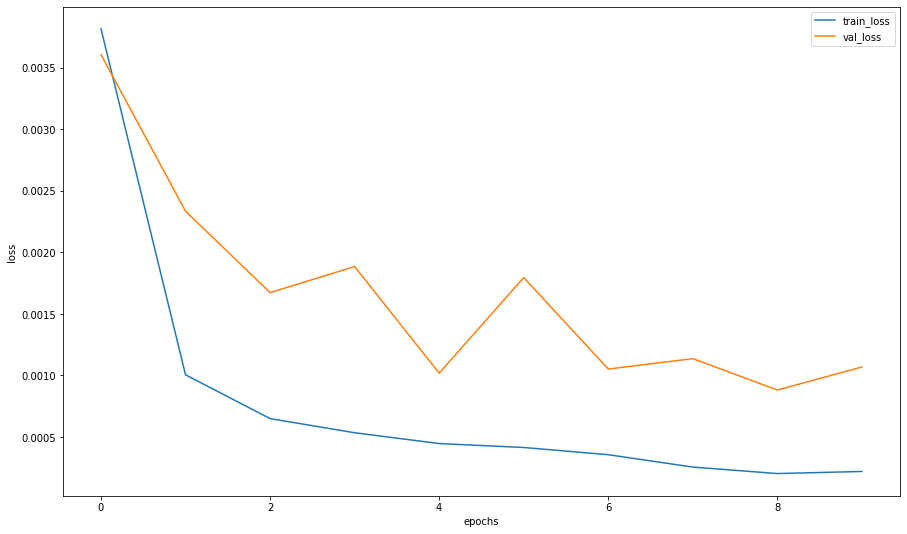

In [46]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

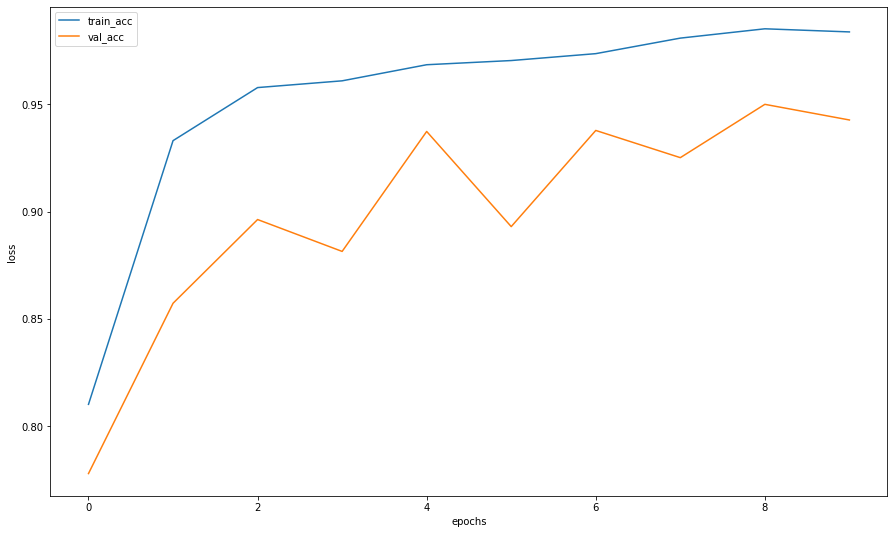

In [47]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Проверим скор на случайном наборе данных

In [48]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [72]:
# выбираем случайные изображения
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

# получаем предикты для этих изображений
probs_ims = predict(model, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
y_pred = np.argmax(probs_ims,-1)

# находим скор
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]
f1_score(actual_labels, y_pred, average='micro')

0.9

## Визуализируем

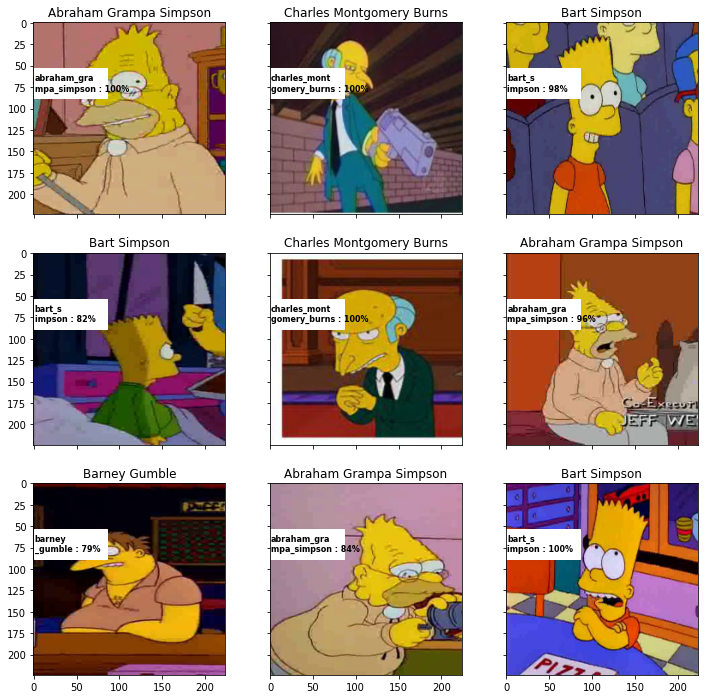

In [76]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

# Submission

In [51]:
test_labels = [path.parent.name for path in train_val_files]
test_dataset = SimpsonsDataset(test_files, mode='test')
test_loader = DataLoader(test_dataset)

In [52]:
import csv

with open('simpsons_submission.csv', 'w') as f:
    writer = csv.DictWriter(f, ['Id', 'Expected'])
    writer.writeheader()
    for img, file_name in test_loader:
        file_name = file_name[0].split('/')[-1]
        img = img.to(DEVICE)
        x = model(img)
        x = torch.argmax(x, 1)
        label = label_encoder.classes_[x]
        writer.writerow({'Id':file_name, 'Expected':label})

## Скор на Kaggle:

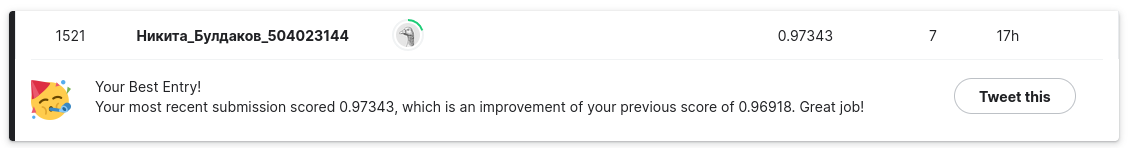